In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

In [10]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed_all(seed)  # For all GPUs
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python random
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
seed = 42
set_seed(seed)

# Mean and standard deviation for normalization (CIFAR-10 specific)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.6),   # Horizontal flip with probability 0.5
    transforms.RandomCrop(32, padding=4),     # Random crop with padding of 4 pixels
    transforms.RandomRotation(15),           # Random rotation of ±15 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Uncomment if needed
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Transformations for the validation and test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Load CIFAR-10 training dataset both augmented and not augmented
dataset_augmented = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
dataset_normal = CIFAR10(root='./data', train=True, download=True, transform=test_transforms)

# Step 3: Suddividere il dataset in Train (80%) e Validation (20%)
train_size = int(0.8 * len(dataset_augmented))  # 80% dei dati
val_size = len(dataset_augmented) - train_size  # 20% dei dati
train_dataset, val_dataset = random_split(dataset_augmented, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
# take validation indices for not augmented dataset
val_dataset = Subset(dataset_normal, val_dataset.indices)
# Load CIFAR-10 dataset for testing
test_dataset = CIFAR10(
    root='./data', train=False, transform=test_transforms, download=True
)
# DataLoader for the training set
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
# DataLoader for the validation set
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=2
)
# DataLoader for the test set
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)
# Output the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Val set size: 10000
Test set size: 10000


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Normalization added
# Dropout to be set  
drop_rate= None
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)  # first dropout added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # dropout after Relu
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.layer_norm = nn.LayerNorm(512) #normalization added
        self.fc = nn.Sequential(
        nn.Dropout(p=drop_rate),  # second dropout before fc
        nn.Linear(512, num_classes)
        )

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, out_channels, stride))
        self.in_planes = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.layer_norm(x)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

In [13]:
# Custom loss function with Square Hinge Loss + L2 Regularization
def square_hinge_loss(outputs, targets, weights, C):
    
    # Create a one-hot tensor for the targets (true classes)
    targets_one_hot = torch.full_like(outputs, -1, device=outputs.device)  # All classes initially set to -1
    targets_one_hot[torch.arange(len(targets)), targets] = 1  # Set the correct class to +1
    
    # Calculate the margin
    margins = 1 - targets_one_hot * outputs  # shape: (n_samples, n_classes)
    # Square hinge loss: max(0, margin)^2
    hinge_loss = torch.clamp(margins, min=0) ** 2  # shape: (n_samples, n_classes)
    
    # Average over all samples and classes
    hinge_loss = hinge_loss.mean()

    # Calculate L2 regularization (mean of squared weights)
    reg_loss = torch.mean(torch.square(weights))
    # Total loss with the regularization parameter C
    total_loss = C * hinge_loss + reg_loss
    
    return total_loss


# C=0.1

In [14]:
# Set model
drop_rate=0.3
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch.to(device)  # Move the model to the specified device (GPU/CPU)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_030_01.pth")

Epoch 1/50:
Train Loss: 0.0358, Train Acc: 35.71%
Val Loss: 0.0270, Val Acc: 49.75%
Epoch 2/50:
Train Loss: 0.0260, Train Acc: 51.65%
Val Loss: 0.0245, Val Acc: 54.58%
Epoch 3/50:
Train Loss: 0.0228, Train Acc: 58.62%
Val Loss: 0.0217, Val Acc: 61.14%
Epoch 4/50:
Train Loss: 0.0211, Train Acc: 62.22%
Val Loss: 0.0194, Val Acc: 65.04%
Epoch 5/50:
Train Loss: 0.0196, Train Acc: 65.25%
Val Loss: 0.0162, Val Acc: 71.35%
Epoch 6/50:
Train Loss: 0.0183, Train Acc: 67.81%
Val Loss: 0.0169, Val Acc: 70.74%
Epoch 7/50:
Train Loss: 0.0172, Train Acc: 70.07%
Val Loss: 0.0158, Val Acc: 72.87%
Epoch 8/50:
Train Loss: 0.0162, Train Acc: 72.02%
Val Loss: 0.0141, Val Acc: 76.08%
Epoch 9/50:
Train Loss: 0.0154, Train Acc: 73.75%
Val Loss: 0.0138, Val Acc: 76.05%
Epoch 10/50:
Train Loss: 0.0149, Train Acc: 74.45%
Val Loss: 0.0125, Val Acc: 78.17%
Epoch 11/50:
Train Loss: 0.0143, Train Acc: 75.73%
Val Loss: 0.0122, Val Acc: 79.19%
Epoch 12/50:
Train Loss: 0.0138, Train Acc: 76.45%
Val Loss: 0.0128, Val A

In [15]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0077, Test Accuracy: 87.60%


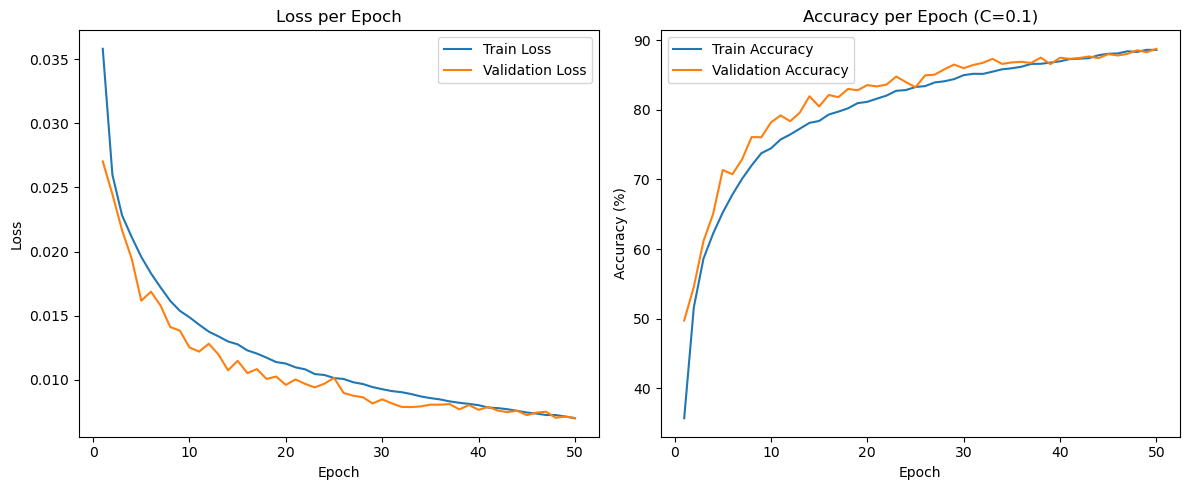

In [16]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=0.1)")
plt.legend()

plt.tight_layout()
plt.show()

# C=1

In [17]:
# Set model
drop_rate=0.3
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch.to(device)  # Move the model to the specified device (GPU/CPU)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_030_1.pth")

Epoch 1/50:
Train Loss: 0.3585, Train Acc: 35.72%
Val Loss: 0.2615, Val Acc: 52.06%
Epoch 2/50:
Train Loss: 0.2597, Train Acc: 51.67%
Val Loss: 0.2270, Val Acc: 58.67%
Epoch 3/50:
Train Loss: 0.2296, Train Acc: 58.26%
Val Loss: 0.1988, Val Acc: 64.91%
Epoch 4/50:
Train Loss: 0.2100, Train Acc: 62.54%
Val Loss: 0.1788, Val Acc: 68.09%
Epoch 5/50:
Train Loss: 0.1925, Train Acc: 65.96%
Val Loss: 0.1769, Val Acc: 69.72%
Epoch 6/50:
Train Loss: 0.1792, Train Acc: 68.39%
Val Loss: 0.1644, Val Acc: 71.94%
Epoch 7/50:
Train Loss: 0.1704, Train Acc: 70.34%
Val Loss: 0.1509, Val Acc: 73.90%
Epoch 8/50:
Train Loss: 0.1620, Train Acc: 71.83%
Val Loss: 0.1387, Val Acc: 75.54%
Epoch 9/50:
Train Loss: 0.1525, Train Acc: 73.69%
Val Loss: 0.1451, Val Acc: 74.58%
Epoch 10/50:
Train Loss: 0.1475, Train Acc: 74.61%
Val Loss: 0.1245, Val Acc: 79.16%
Epoch 11/50:
Train Loss: 0.1419, Train Acc: 75.64%
Val Loss: 0.1229, Val Acc: 78.78%
Epoch 12/50:
Train Loss: 0.1360, Train Acc: 76.58%
Val Loss: 0.1212, Val A

In [18]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0765, Test Accuracy: 87.85%


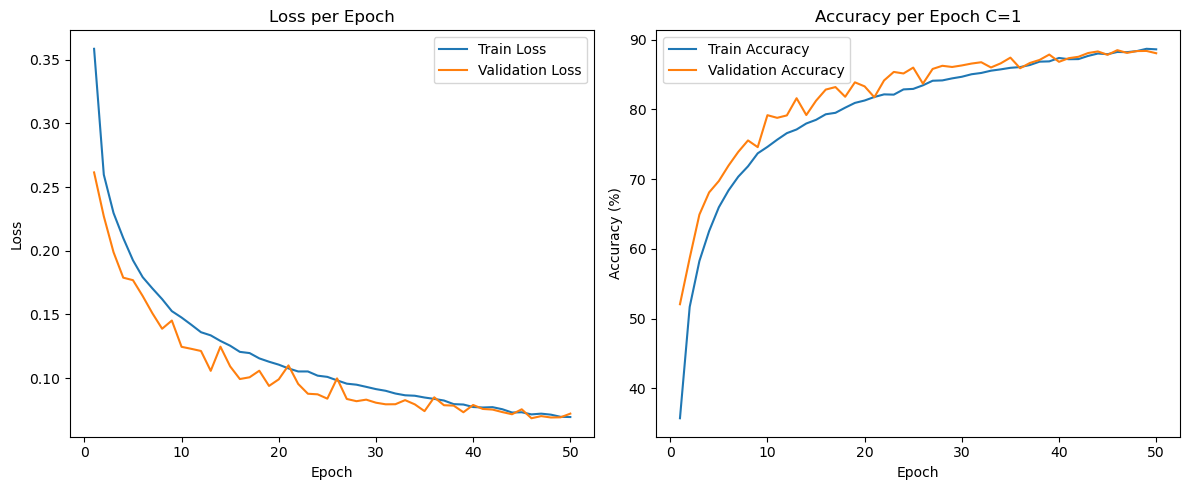

In [19]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch C=1")
plt.legend()

plt.tight_layout()
plt.show()

# C=10

In [20]:
# Set model
drop_rate=0.3
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch.to(device)  # Move the model to the specified device (GPU/CPU)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_030_10.pth")

Epoch 1/50:
Train Loss: 3.5682, Train Acc: 35.73%
Val Loss: 2.6030, Val Acc: 50.55%
Epoch 2/50:
Train Loss: 2.5807, Train Acc: 51.88%
Val Loss: 2.1354, Val Acc: 61.45%
Epoch 3/50:
Train Loss: 2.2750, Train Acc: 58.43%
Val Loss: 2.0659, Val Acc: 63.15%
Epoch 4/50:
Train Loss: 2.0862, Train Acc: 62.69%
Val Loss: 1.8531, Val Acc: 66.89%
Epoch 5/50:
Train Loss: 1.9331, Train Acc: 65.81%
Val Loss: 1.6734, Val Acc: 70.86%
Epoch 6/50:
Train Loss: 1.7914, Train Acc: 68.78%
Val Loss: 1.7649, Val Acc: 69.39%
Epoch 7/50:
Train Loss: 1.6911, Train Acc: 70.76%
Val Loss: 1.4616, Val Acc: 74.51%
Epoch 8/50:
Train Loss: 1.6022, Train Acc: 72.24%
Val Loss: 1.3863, Val Acc: 75.68%
Epoch 9/50:
Train Loss: 1.5311, Train Acc: 73.56%
Val Loss: 1.3514, Val Acc: 76.68%
Epoch 10/50:
Train Loss: 1.4576, Train Acc: 75.08%
Val Loss: 1.3485, Val Acc: 77.41%
Epoch 11/50:
Train Loss: 1.4132, Train Acc: 75.82%
Val Loss: 1.1855, Val Acc: 79.41%
Epoch 12/50:
Train Loss: 1.3568, Train Acc: 76.58%
Val Loss: 1.1627, Val A

In [21]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.7101, Test Accuracy: 87.91%


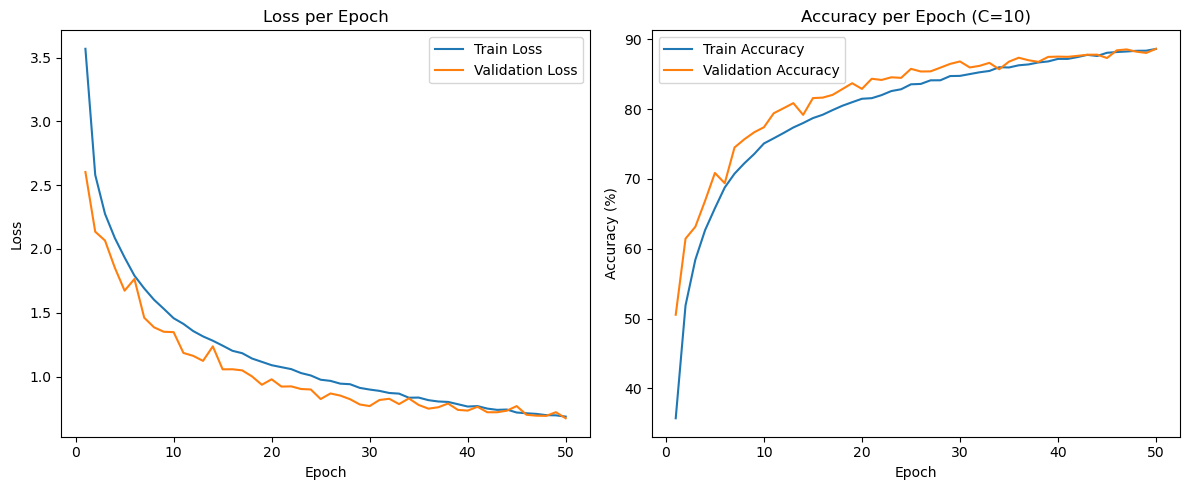

In [22]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=10)")
plt.legend()

plt.tight_layout()
plt.show()

# C=100

In [23]:
# Set model
drop_rate=0.3
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch.to(device)  # Move the model to the specified device (GPU/CPU)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_030_100.pth")

Epoch 1/50:
Train Loss: 35.6162, Train Acc: 35.73%
Val Loss: 25.2683, Val Acc: 52.51%
Epoch 2/50:
Train Loss: 25.7800, Train Acc: 51.60%
Val Loss: 23.9373, Val Acc: 57.05%
Epoch 3/50:
Train Loss: 22.6618, Train Acc: 58.77%
Val Loss: 21.1226, Val Acc: 62.56%
Epoch 4/50:
Train Loss: 20.7059, Train Acc: 62.85%
Val Loss: 22.2632, Val Acc: 60.27%
Epoch 5/50:
Train Loss: 19.1923, Train Acc: 65.95%
Val Loss: 17.2025, Val Acc: 69.86%
Epoch 6/50:
Train Loss: 17.9756, Train Acc: 68.42%
Val Loss: 16.2138, Val Acc: 71.67%
Epoch 7/50:
Train Loss: 16.8765, Train Acc: 70.56%
Val Loss: 13.5219, Val Acc: 76.49%
Epoch 8/50:
Train Loss: 16.0037, Train Acc: 72.13%
Val Loss: 13.6601, Val Acc: 76.27%
Epoch 9/50:
Train Loss: 15.1079, Train Acc: 73.92%
Val Loss: 12.7464, Val Acc: 78.13%
Epoch 10/50:
Train Loss: 14.6034, Train Acc: 74.80%
Val Loss: 12.9508, Val Acc: 77.97%
Epoch 11/50:
Train Loss: 14.0201, Train Acc: 75.69%
Val Loss: 11.5558, Val Acc: 80.05%
Epoch 12/50:
Train Loss: 13.5837, Train Acc: 76.51%


In [24]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 7.6477, Test Accuracy: 87.47%


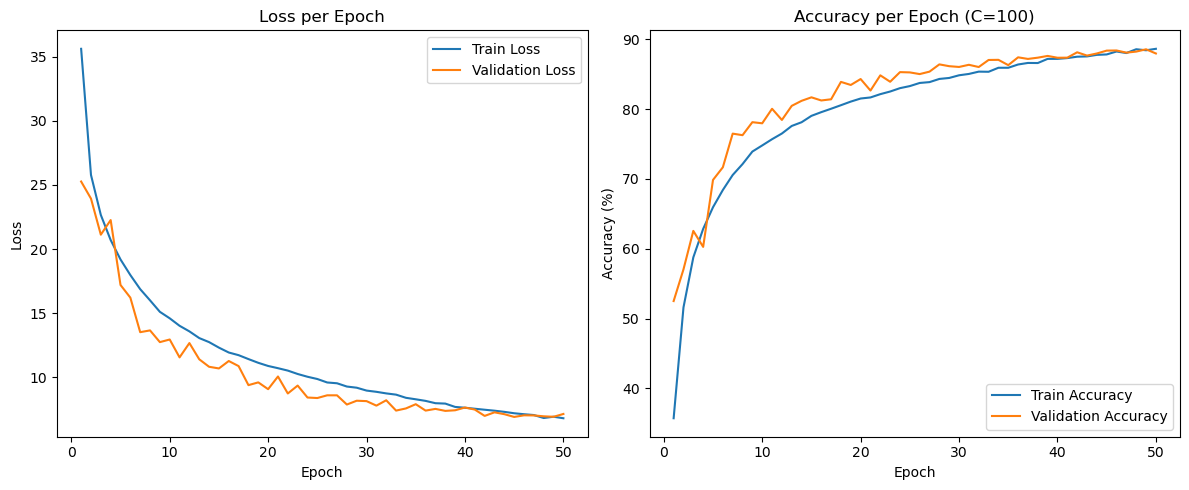

In [25]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=100)")
plt.legend()

plt.tight_layout()
plt.show()

# C=1000

In [26]:
# Set model
drop_rate=0.3
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch.to(device)  # Move the model to the specified device (GPU/CPU)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 1000)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 1000)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_030_1000.pth")

Epoch 1/50:
Train Loss: 359.4245, Train Acc: 35.69%
Val Loss: 263.6389, Val Acc: 50.25%
Epoch 2/50:
Train Loss: 261.5298, Train Acc: 51.10%
Val Loss: 243.7261, Val Acc: 55.42%
Epoch 3/50:
Train Loss: 228.3386, Train Acc: 58.34%
Val Loss: 197.5471, Val Acc: 64.89%
Epoch 4/50:
Train Loss: 207.6049, Train Acc: 62.84%
Val Loss: 179.6951, Val Acc: 67.33%
Epoch 5/50:
Train Loss: 192.4055, Train Acc: 65.86%
Val Loss: 164.3731, Val Acc: 70.73%
Epoch 6/50:
Train Loss: 179.3600, Train Acc: 68.40%
Val Loss: 154.3243, Val Acc: 73.02%
Epoch 7/50:
Train Loss: 168.7112, Train Acc: 70.64%
Val Loss: 156.0888, Val Acc: 72.99%
Epoch 8/50:
Train Loss: 161.3884, Train Acc: 71.94%
Val Loss: 134.5084, Val Acc: 76.40%
Epoch 9/50:
Train Loss: 153.9246, Train Acc: 73.18%
Val Loss: 129.8354, Val Acc: 77.59%
Epoch 10/50:
Train Loss: 146.6050, Train Acc: 74.80%
Val Loss: 136.9860, Val Acc: 76.87%
Epoch 11/50:
Train Loss: 141.3500, Train Acc: 75.39%
Val Loss: 118.6700, Val Acc: 79.38%
Epoch 12/50:
Train Loss: 136.1

In [27]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 74.5809, Test Accuracy: 87.80%


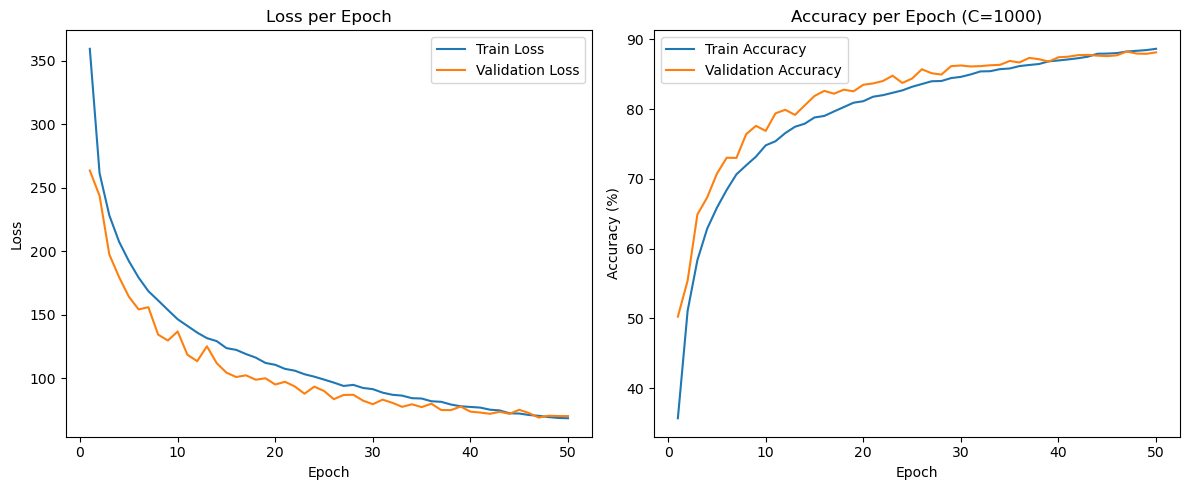

In [28]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=1000)")
plt.legend()

plt.tight_layout()
plt.show()